In [1]:
state = 'NM'    # 2-letter state code
k = 3           # number of districts

In [2]:
# Read county graph from the json file "<state>_county.json"
filepath = 'C:\\districting-data-2020\\'
filename = state + '_county.json'

# GerryChain has a built-in function for reading graphs of this type:
from gerrychain import Graph
G = Graph.from_json( filepath + filename )

for node in G.nodes:
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']

In [3]:
# Let's impose a 1% population deviation (+/-0.5%)
deviation = 0.01
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes )

import math
L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 702312 and U = 709369 and k = 3


In [4]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

import networkx as nx
DG = nx.DiGraph(G)   # directed version of G

# create variables
# x[i,j] equals one when county i is assigned to district j
x = m.addVars(G.nodes, k, vtype=GRB.BINARY)  

# y[u,v,j] equals one when arc (u,v) is cut because u->j but not v->j
y = m.addVars(DG.edges, k, vtype=GRB.BINARY) 

# z[j] is inverse Polsby-Popper score for district j
z = m.addVars(k)

# A[j] = area of district j
A = m.addVars(k)

# P[j] = perimeter of district j
P = m.addVars(k)

for j in range(k):
    z[j].lb = 0
    A[j].lb = 0
    P[j].lb = 0

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-01


In [5]:
# objective is to minimize sum of inverse Polsby-Popper scores
coef = 1 / ( 2 * math.pi )
m.setObjective( coef * gp.quicksum( z[j] for j in range(k) ), GRB.MINIMIZE )

In [6]:
# add SOCP constraints relating inverse Polsby-Popper score z[j] to area and perimeter
m.addConstrs( P[j] * P[j] <= 2 * A[j] * z[j] for j in range(k) )

# add constraints on areas A[j] 
m.addConstrs( A[j] == gp.quicksum( G.nodes[i]['area'] * x[i,j] for i in G.nodes ) for j in range(k) )

# add constraints on perimeters P[j]
for j in range(k):
    m.addConstr( P[j] == gp.quicksum( DG.edges[u,v]['shared_perim'] * y[u,v,j] for u,v in DG.edges )
             + gp.quicksum( G.nodes[i]['boundary_perim'] * x[i,j] for i in G.nodes if G.nodes[i]['boundary_node'] ) )
    
m.update()

In [7]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in range(k)) == 1 for i in G.nodes )

# add constraints saying that each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {u,v} is cut if u is assigned to district j but v is not.
m.addConstrs( x[u,j] - x[v,j] <= y[u,v,j] for u,v in DG.edges for j in range(k) )

m.update()

In [8]:
# Now, let's add contiguity constraints and re-solve the model.
# We will use the contiguity constraints of Hojny et al. (MPC, 2021)
#   https://link.springer.com/article/10.1007/s12532-020-00186-3

# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
r = m.addVars( G.nodes, k, vtype=GRB.BINARY)

# To solve the MIP faster, fix a district root:
r[0,0].LB = 1

# Add flow variables: f[u,v] = amount of flow sent across arc uv 
#  Flows are sent across arcs of the directed version of G which we call DG

f = m.addVars( DG.edges )

In [9]:
# The big-M proposed by Hojny et al.
M = G.number_of_nodes() - k + 1

# Each district j should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in G.nodes ) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in G.nodes for j in range(k) ) 

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i) ) 
             >= 1 - M * gp.quicksum( r[i,j] for j in range(k) ) for i in G.nodes )

# do not send flow across cut edges
m.addConstrs( f[u,v] + f[v,u] <= M * ( 1 - gp.quicksum( y[u,v,j] for j in range(k) ) ) for u,v in DG.edges )

m.update()

In [10]:
# solve IP model
m.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 804 rows, 831 columns and 3816 nonzeros
Model fingerprint: 0xa1d5fb6c
Model has 3 quadratic constraints
Variable types: 165 continuous, 666 integer (666 binary)
Coefficient statistics:
  Matrix range     [3e-02, 7e+05]
  QMatrix range    [1e+00, 2e+00]
  Objective range  [2e-01, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 70 rows and 64 columns
Presolve time: 0.03s
Presolved: 734 rows, 767 columns, 3520 nonzeros
Presolved model has 3 quadratic constraint(s)
Variable types: 159 continuous, 608 integer (608 binary)

Root relaxation: objective 1.409875e-02, 290 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.01410    0    4      

In [11]:
print("The objective value is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The objective value is 7.280329910476729
District 0 has population 702632 and contains counties ['Curry', 'San Juan', 'Guadalupe', 'McKinley', 'Rio Arriba', 'Santa Fe', 'Quay', 'Union', 'San Miguel', 'Taos', 'Colfax', 'Sandoval', 'Harding', 'Los Alamos', 'Mora']

District 1 has population 707695 and contains counties ['Roosevelt', 'Lincoln', 'Torrance', 'Luna', 'Lea', 'Chaves', 'Sierra', 'Valencia', 'De Baca', 'Otero', 'Grant', 'Doña Ana', 'Hidalgo', 'Socorro', 'Eddy']

District 2 has population 707195 and contains counties ['Bernalillo', 'Catron', 'Cibola']



In [12]:
# Let's draw it on a map
import geopandas as gpd

In [13]:
# Read county shapefile from "<state>_county.shp"
filename = state + '_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

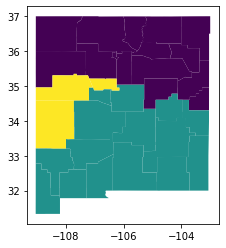

In [14]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]

labeling = { i : j for i in G.nodes for j in range(k) if x[i,j].x > 0.5 }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()